In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as metrics

from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from imblearn.over_sampling import RandomOverSampler
import pickle

In [4]:
#Datos de Diabetes
datos_diabetes = pd.read_csv('/home/juan/machineLearning2025/datasets/diabetes_012_health_indicators_BRFSS2015.csv')

#Crear la columna diabetes_01 que unifique prediabetes con diabetes
datos_diabetes['diabetes_01'] = datos_diabetes['Diabetes_012']
datos_diabetes['diabetes_01'] = datos_diabetes['diabetes_01'].replace(2,1)

#Reparar nombres de columnas. Se usa el formato loweCamelCase para el nombre de las caracteristicas.

new_col_names = []

for name in datos_diabetes.columns:
    # Luego, pon todas las letras en minúsculas
    name_lowered_first_letter = name[0].lower() + name[1:]
    # Elimina los espacios al principio y al final
    name_stripped = name_lowered_first_letter.strip()
    # Por último, reemplaza los espacios entre palabras por guiones bajos
    name_no_spaces = name_stripped.replace(' ', '_')
    # Agrega el nuevo nombre a la lista de nuevos nombres de columna
    new_col_names.append(name_no_spaces)

datos_diabetes.columns = new_col_names

datos_diabetes = datos_diabetes.rename(columns={'bMI':'bmi'})

datos_diabetes.columns


#Definicion de datos enteros.
for col in datos_diabetes.columns:
    #if datos_diabetes[col].dtype == 'float64':
    datos_diabetes[col] = datos_diabetes[col].astype(int)

In [5]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
   
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')   
        
        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    #print(df_eval_stats)
    
    return  df_eval_stats, fig#eval_stats['train']['F1'], eval_stats['test']['F1']

In [6]:
from sklearn.model_selection import train_test_split
X = datos_diabetes.drop(["diabetes_01", "diabetes_012"], axis=1)
y = datos_diabetes["diabetes_01"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [ ]:
#RandFOrest modelo balanceado
model_balancedRandomForest = BalancedRandomForestClassifier(random_state=54321, n_jobs=-1)

param_grid = {
    'n_estimators': [10, 30, 50, 70, 90, 100],
    'max_features': [4, 10, 20],  
    'max_depth': [10, 20, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


grid_search_balancedRandomForest = GridSearchCV(model_balancedRandomForest, param_grid,cv=5, scoring='f1')
grid_search_balancedRandomForest.fit(X_train, y_train)
print("Mejores parámetros encontrados por Grid Search:", grid_search_balancedRandomForest.best_params_)
print("(F1) del mejor modelo en el conjunto de validación:", grid_search_balancedRandomForest.best_score_)

Mejores parámetros encontrados por Grid Search: {'max_depth': 20, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
(F1) del mejor modelo en el conjunto de validación: 0.4770369290329725


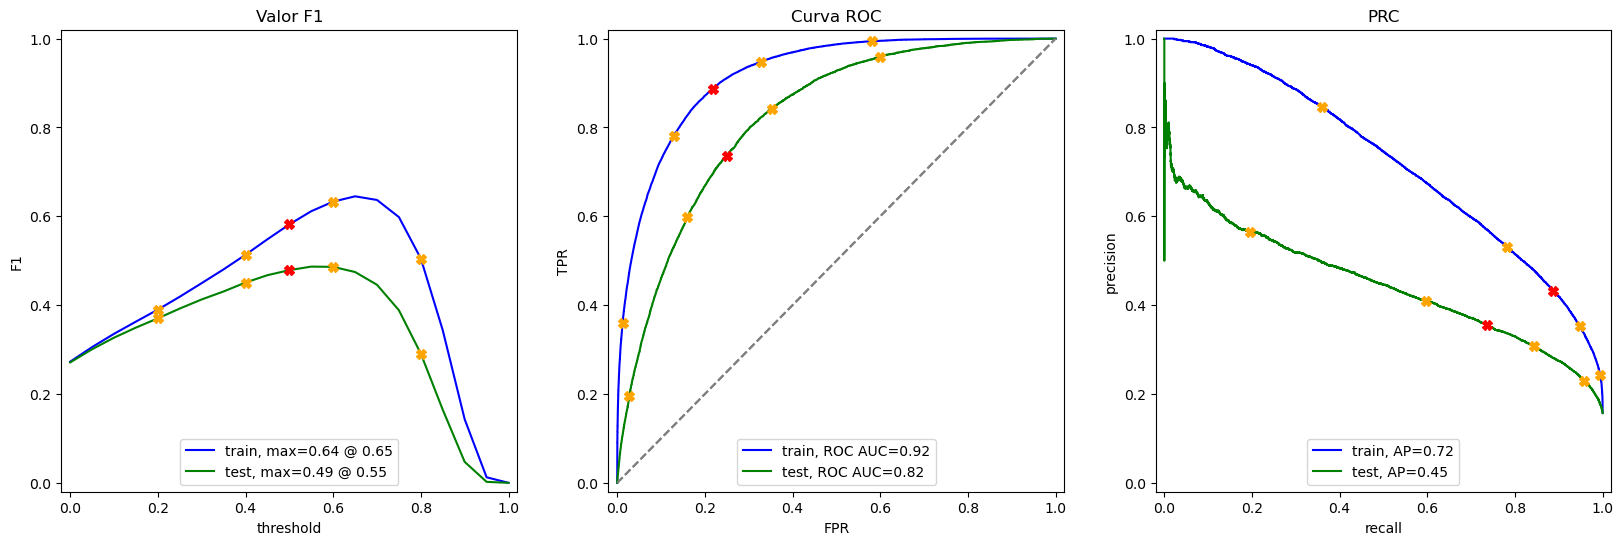

In [ ]:
with open("balancedRandomForest.pkl", 'wb') as file:
    pickle.dump(grid_search_balancedRandomForest.best_estimator_, file)

with open("balancedRandomForest.pkl", 'rb') as file:  
    model = pickle.load(file)
df_metrics, fig =evaluate_model(model, X_train, y_train, X_test, y_test)

df_metrics.to_csv('metrics_balancedRandomForest.csv')

with open('fig_balancedRandomForest.pkl', 'wb') as f:
    pickle.dump(fig, f)


In [7]:
X_train_best4= X_train[['bmi', 'age', 'income', 'genHlth']]
X_test_best4 =X_test[['bmi', 'age', 'income', 'genHlth']]

#RandFOrest modelo desbalanceadpo
model_balancedRandomForest_best4 = BalancedRandomForestClassifier(random_state=54321, n_jobs=-1)

param_grid_best4 = {
    'n_estimators': [10, 30, 50, 70, 90, 100],
    'max_features': [4, 10, 20],  
    'max_depth': [10, 20, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_balancedRandomForest_best4 = GridSearchCV(model_balancedRandomForest_best4, param_grid_best4,cv=5, scoring='f1')
grid_search_balancedRandomForest_best4.fit(X_train_best4, y_train)
print("Mejores parámetros encontrados por Grid Search:", grid_search_balancedRandomForest_best4.best_params_)
print("(F1) del mejor modelo en el conjunto de validación:", grid_search_balancedRandomForest_best4.best_score_)

KeyboardInterrupt: 

In [ ]:
with open("balancedRandomForest_best4.pkl", 'wb') as file:
    pickle.dump(grid_search_balancedRandomForest_best4.best_estimator_, file)

with open("balancedRandomForest_best4.pkl", 'rb') as file:  
    model = pickle.load(file)
df_metrics, fig =evaluate_model(model, X_train_best4, y_train, X_test_best4, y_test)

df_metrics.to_csv('metrics_balancedRandomForest_best4.csv')

with open('fig_balancedRandomForest_best4.pkl', 'wb') as f:
    pickle.dump(fig, f)